# <center>Segmenta Project:<br> Customer Segmentation</center>

<div style="text-align: center;">
  <img src="https://plus.unsplash.com/premium_photo-1683116663524-5a8a50ec79a4?q=80&w=1932&auto=format&fit=crop&ixlib=rb-4.0.3&ixid=M3wxMjA3fDB8MHxwaG90by1wYWdlfHx8fGVufDB8fHx8fA%3D%3D" alt="shopping trolleys" style="width: 600px;">
</div>

## Overview

A data analytics project focused on customer segmentation. This project aims to analyse customer behaviour and characteristics to identify distinct segments, helping businesses tailor their marketing strategies for optimal impact.

Features to Implement:
- Data preprocessing and cleaning.
- Application of clustering algorithms for segmentation.
- Visualisation of customer segments.
- Analysis of segment characteristics and insights.
- Dataset Suggestion: The project can use the Online Retail Dataset from the UCI Machine Learning Repository, but you may use any dataset you deem as suitable

Technologies:
- Programming: Python (Pandas, NumPy, Matplotlib, Seaborn)
- Machine Learning: scikit-learn
- Visualisation: Matplotlib, Seaborn

First Steps:
- Introduction to the project's purpose and goals.
- Discussion of the dataset and its relevance.
- Overview of the clustering algorithms and analysis techniques.
- Clarification of roles and responsibilities for each team member.
- Setting up communication channels for efficient collaboration.
- Project timeline review and milestone definition.
- Q&A session for any inquiries.
- Next Steps:

Familiarize yourself with the dataset.
- Begin data exploration and pre-processing.
- Assign roles and responsibilities for each phase.
- Schedule regular update meetings to ensure progress tracking.

## Objectives

- Perform exploratory data analysis on the dataset to understand customer attributes.
- Implement clustering algorithms to segment customers based on their behaviour and characteristics.
- Visualise  customer segments.
- Interpret the identified groups
- Create suggestions for the business 

## Contents
- 1.0 The dataset
- 2.0 EDA
- 3.0 K-means clustering
- 4.0 Sentiment Analysis
- 5.0 Performance Analysis
- 6.0 Toxic comment classifier
- 7.0 Conclusions and Limitations

## 1.0 The dataset

### 1.1 Data importing

In [225]:
import pandas as pd
import numpy as np
import scipy

# Libraries for visualisations
import seaborn as sns 
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer

# Clustering
from sklearn.cluster import KMeans
from sklearn.metrics import davies_bouldin_score, silhouette_score

from sklearn.decomposition import PCA

import pickle

In [16]:
# Import data from csv files
df = pd.read_csv('Online Retail - Online Retail.csv', header=None)
retail_df = df.copy()
retail_df.columns = retail_df.iloc[0] # Set our column headers
retail_df = retail_df[1:]

C:\Users\olive\AppData\Local\Temp\ipykernel_15772\841174412.py:2: DtypeWarning: Columns (3,5,6) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('Online Retail - Online Retail.csv', header=None)


In [17]:
# A first look at the data
retail_df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
1,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/10 8:26,2.55,17850,United Kingdom
2,536365,71053,WHITE METAL LANTERN,6,12/1/10 8:26,3.39,17850,United Kingdom
3,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/10 8:26,2.75,17850,United Kingdom
4,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/10 8:26,3.39,17850,United Kingdom
5,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/10 8:26,3.39,17850,United Kingdom


In [18]:
# Check number of observations and columns
retail_df.shape

(541909, 8)

In [19]:
retail_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 1 to 541909
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype 
---  ------       --------------   ----- 
 0   InvoiceNo    541909 non-null  object
 1   StockCode    541909 non-null  object
 2   Description  540455 non-null  object
 3   Quantity     541909 non-null  object
 4   InvoiceDate  541909 non-null  object
 5   UnitPrice    541909 non-null  object
 6   CustomerID   406829 non-null  object
 7   Country      541909 non-null  object
dtypes: object(8)
memory usage: 33.1+ MB


**Note: No null values exept in CustomerID column.**

## 2.0 Exploratory Data Analysis

### Converting data types for analysis

In [24]:
# Convert data types
retail_df['Description'] = retail_df['Description'].astype(str)
retail_df['Quantity'] = retail_df['Quantity'].astype(int)
retail_df['UnitPrice'] = retail_df['UnitPrice'].astype(float)
retail_df['Country'] = retail_df['Country'].astype(str)
# Convert InvoiceDate to datetime format
retail_df['InvoiceDate'] = pd.to_datetime(retail_df['InvoiceDate'], format='%m/%d/%y %H:%M')

# Display the data types to confirm
print(retail_df.dtypes)

0
InvoiceNo              object
StockCode              object
Description            object
Quantity                int32
InvoiceDate    datetime64[ns]
UnitPrice             float64
CustomerID             object
Country                object
dtype: object


### 2.1 Exploring retail data

In [26]:
min_value = retail_df['Quantity'].min()
max_value = retail_df['Quantity'].max()

print(f"Max = {max_value}, Min = {min_value}")

Max = 80995, Min = -80995


**Note: From the checks we see that cancelled orders give negative quantity values. We can seperate these into two seperate dataframes.**

In [28]:
max_row = retail_df[retail_df['Quantity'] == 80995]
min_row = retail_df[retail_df['Quantity'] == -80995]
min_max = pd.concat([max_row, min_row], ignore_index=True)

min_max

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,581483,23843,"PAPER CRAFT , LITTLE BIRDIE",80995,2011-12-09 09:15:00,2.08,16446.0,United Kingdom
1,C581484,23843,"PAPER CRAFT , LITTLE BIRDIE",-80995,2011-12-09 09:27:00,2.08,16446.0,United Kingdom


**Note: As we can see the cancelled orders retain the original order(different invoiceNo) in the dataset which is misleading as the order did not result in any sales therefore, we should remove the original order and seperate the cancelled order into a seperate dataframe.**

### 2.11 Creating seperate dataframes for completed and cancelled orders

In [31]:
# Example: fill NaN values with a placeholder (CustomerID)
retail_df = retail_df.fillna('Unknown')  # Replace NaN with 'Unknown' or appropriate placeholder


# Separate the DataFrame into positive and negative quantities
positive_df = retail_df[retail_df['Quantity'] > 0].copy()
negative_df = retail_df[retail_df['Quantity'] < 0].copy()

# Create a unique identifier for matching rows
positive_df['identifier'] = (positive_df['StockCode'].astype(str) + '_' +
                              positive_df['Description'].astype(str) + '_' +
                              positive_df['UnitPrice'].astype(str) + '_' +
                              positive_df['CustomerID'].astype(str) + '_' +
                              positive_df['Country'].astype(str))

negative_df['identifier'] = (negative_df['StockCode'].astype(str) + '_' +
                              negative_df['Description'].astype(str) + '_' +
                              negative_df['UnitPrice'].astype(str) + '_' +
                              negative_df['CustomerID'].astype(str) + '_' +
                              negative_df['Country'].astype(str))

# Find matching positive and negative rows
merged_df = pd.merge(
    positive_df,
    negative_df,
    on='identifier',
    suffixes=('_positive', '_negative'),
    how='inner'  # Ensure that only matching rows are kept
)

# Filter to find exact quantity matches (positive with corresponding negative)
matching_pairs = merged_df[merged_df['Quantity_positive'] == -merged_df['Quantity_negative']]

# Get identifiers of rows to remove from the positive DataFrame
identifiers_to_remove = matching_pairs['identifier'].unique()

# Remove matching positive rows
cleaned_positive_df = positive_df[~positive_df['identifier'].isin(identifiers_to_remove)]

# Create DataFrame for cancelled orders (all negative quantities)
cancelled_order_df = negative_df[~negative_df['identifier'].isin(
    matching_pairs['identifier'].unique())]

# Remove the additional identifier columns
cleaned_positive_df = cleaned_positive_df.drop(columns=['identifier'])
cancelled_order_df = cancelled_order_df.drop(columns=['identifier'])

In [32]:
# Checking our completed order dataframe
cleaned_positive_df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
1,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850,United Kingdom
2,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850,United Kingdom
3,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850,United Kingdom
4,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850,United Kingdom
5,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850,United Kingdom


### 2.12 Checking how quantity changes with Unit price

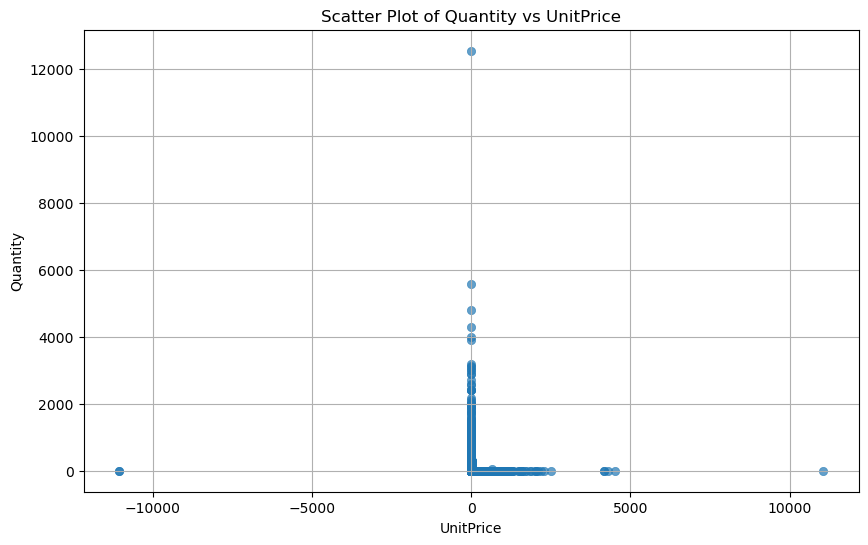

In [34]:
# Scatter plot of Quantity vs UnitPrice
plt.figure(figsize=(10, 6))
sns.scatterplot(data=cleaned_positive_df, x='UnitPrice', y='Quantity', alpha=0.7, edgecolor=None)
plt.title('Scatter Plot of Quantity vs UnitPrice')
plt.xlabel('UnitPrice')
plt.ylabel('Quantity')
plt.grid(True)
plt.show()

**Note: Unsuprisingly we can see that the cheaper items tend to be bought in higher quantities however what is suprising is that the is a negative value for unitprice.**

In [36]:
min_value = cleaned_positive_df['UnitPrice'].min()
max_value = cleaned_positive_df['UnitPrice'].max()

print(f"Max = {max_value}, Min = {min_value}")

Max = 11062.06, Min = -11062.06


In [37]:
max_row = cleaned_positive_df[cleaned_positive_df['UnitPrice'] == 11062.06]
min_row = cleaned_positive_df[cleaned_positive_df['UnitPrice'] == -11062.06]
min_max = pd.concat([max_row, min_row], ignore_index=True)

min_max

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,A563185,B,Adjust bad debt,1,2011-08-12 14:50:00,11062.06,Unknown,United Kingdom
1,A563186,B,Adjust bad debt,1,2011-08-12 14:51:00,-11062.06,Unknown,United Kingdom
2,A563187,B,Adjust bad debt,1,2011-08-12 14:52:00,-11062.06,Unknown,United Kingdom


**Note: It looks like this cancelled order was entered twice into the dataframe.**

In [39]:
max_row = cleaned_positive_df[cleaned_positive_df['InvoiceNo'] == 'A563185']
max_row

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
299983,A563185,B,Adjust bad debt,1,2011-08-12 14:50:00,11062.06,Unknown,United Kingdom


In [40]:
min_row = cleaned_positive_df[cleaned_positive_df['InvoiceNo'] == 'A563186']
min_row

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
299984,A563186,B,Adjust bad debt,1,2011-08-12 14:51:00,-11062.06,Unknown,United Kingdom


In [41]:
min_row = cleaned_positive_df[cleaned_positive_df['InvoiceNo'] == 'A563187']
min_row

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
299985,A563187,B,Adjust bad debt,1,2011-08-12 14:52:00,-11062.06,Unknown,United Kingdom


**Looking at this the InvoiceNo is unique and we can simply delete the original order (and one cancelled order) and transfer the other cancelled orders to the cancelled df.**

In [43]:
# Condition for selecting the row to move
InvoiceNo_move = 'A563186'

# Select the row(s) to move
row_to_move = cleaned_positive_df[cleaned_positive_df['InvoiceNo'] == InvoiceNo_move]

# Remove the selected row from the original DataFrame
cleaned_positive_df = cleaned_positive_df[cleaned_positive_df['InvoiceNo'] != InvoiceNo_move]

# Append the selected row to the new DataFrame
cancelled_order_df = pd.concat([cancelled_order_df, row_to_move], ignore_index=True)
cancelled_order_df.tail(2)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
7391,C581569,20979,36 PENCILS TUBE RED RETROSPOT,-5,2011-12-09 11:58:00,1.25,17315.0,United Kingdom
7392,A563186,B,Adjust bad debt,1,2011-08-12 14:51:00,-11062.06,Unknown,United Kingdom


In [44]:
# Values to remove
InvoiceNo = ['A563185', 'A563187']

# Remove rows where 'InvoiceNo' is in the specified list
cleaned_positive_df = cleaned_positive_df[~cleaned_positive_df['InvoiceNo'].isin(InvoiceNo)]

### Revisiting how quantity changes with Unit price

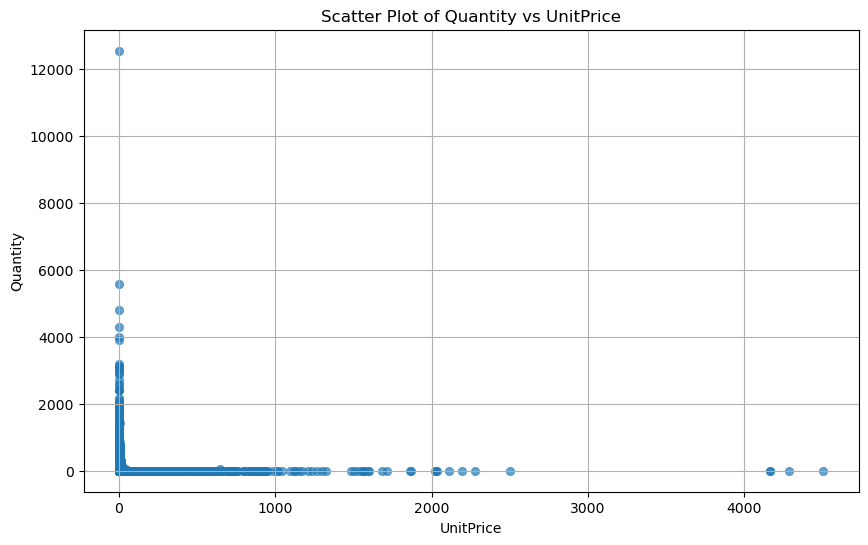

In [46]:
# Scatter plot of Quantity vs UnitPrice
plt.figure(figsize=(10, 6))
sns.scatterplot(data=cleaned_positive_df, x='UnitPrice', y='Quantity', alpha=0.7, edgecolor=None)
plt.title('Scatter Plot of Quantity vs UnitPrice')
plt.xlabel('UnitPrice')
plt.ylabel('Quantity')
plt.grid(True)
plt.show()

### 2.13 Determining wherther to keep description as a feature column

In [49]:
unique_values = cleaned_positive_df['Description'].unique()

# Number of unique values
num_unique_values = len(unique_values)

print(f'Number of unique values: {num_unique_values}')

Number of unique values: 4070


**Note: With so many different products the data becomes high-dimensional. In such high-dimensional spaces, the notion of "distance" between data points becomes less significant, potentially impairing the effectiveness of distance-based algorithms like K-means.**

### 2.20 Data Preprocessing

### 2.21 Checking for nulls

In [53]:
cleaned_positive_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 523845 entries, 1 to 541909
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    523845 non-null  object        
 1   StockCode    523845 non-null  object        
 2   Description  523845 non-null  object        
 3   Quantity     523845 non-null  int32         
 4   InvoiceDate  523845 non-null  datetime64[ns]
 5   UnitPrice    523845 non-null  float64       
 6   CustomerID   523845 non-null  object        
 7   Country      523845 non-null  object        
dtypes: datetime64[ns](1), float64(1), int32(1), object(5)
memory usage: 34.0+ MB


**Note: No nulls in the dataset.**

### 2.22 Checking for duplicates

**There should be no duplicate rows since even for products within the same order (invoice number) they are seperated with different products and varying quantities.**

In [57]:
# Find duplicate rows
duplicates = cleaned_positive_df[cleaned_positive_df.duplicated()]

# Display the duplicates
print(duplicates)

0      InvoiceNo StockCode                        Description  Quantity  \
518       536409     21866        UNION JACK FLAG LUGGAGE TAG         1   
528       536409     22866      HAND WARMER SCOTTY DOG DESIGN         1   
538       536409     22900    SET 2 TEA TOWELS I LOVE LONDON          1   
540       536409     22111       SCOTTIE DOG HOT WATER BOTTLE         1   
556       536412     22327  ROUND SNACK BOXES SET OF 4 SKULLS         1   
...          ...       ...                                ...       ...   
541676    581538     22068        BLACK PIRATE TREASURE CHEST         1   
541690    581538     23318     BOX OF 6 MINI VINTAGE CRACKERS         1   
541693    581538     22992             REVOLVER WOODEN RULER          1   
541700    581538     22694                       WICKER STAR          1   
541702    581538     23343       JUMBO BAG VINTAGE CHRISTMAS          1   

0              InvoiceDate  UnitPrice CustomerID         Country  
518    2010-12-01 11:45:00      

In [58]:
# 5128 Duplicate rows found - Must be removed.

# Dropping duplicates
cleaned_positive_df = cleaned_positive_df.drop_duplicates()

In [59]:
# Checking if duplicaes removed
num_duplicates = cleaned_positive_df.duplicated().sum()
print(f"Total number of duplicate rows: {num_duplicates}")

Total number of duplicate rows: 0


**Note: All duplicate observations have been removed.**

### 2.23 Creating a day of the week / month / time column

In [62]:
# Extract day of the week (0=Monday, 6=Sunday)
cleaned_positive_df['DayOfWeek'] = cleaned_positive_df['InvoiceDate'].dt.dayofweek

# Extract month (1=January, 12=December)
cleaned_positive_df['Month'] = cleaned_positive_df['InvoiceDate'].dt.month

In [63]:
cleaned_positive_df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,DayOfWeek,Month
1,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850,United Kingdom,2,12
2,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,2,12
3,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850,United Kingdom,2,12
4,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,2,12
5,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,2,12


### 2.24 Removing non-useful columns

**Columns to Exclude**

**InvoiceNo:** A unique identifier for transactions, not useful for clustering.

**StockCode:** A unique identifier for products. May not be useful directly, but product categories could be more useful if available.

**InvoiceDate:** </br> Already converted into seperate columns:
- Day of the week: To understand if certain customers purchase more on specific days.
- Month: To identify seasonal buying patterns.
- Time of day: If time information is available, it can indicate peak purchasing times.

**CustomerID:** Unique identifier for customers, not useful for clustering directly. However, customer-related features like total spent, frequency, etc., could be useful.

In [66]:
# Separate the CustomerID column - For referencing
customer_ids = cleaned_positive_df['CustomerID']
customer_ids = cleaned_positive_df['Country']

# Drop the specified columns
columns_to_drop = ['InvoiceNo', 'StockCode', 'Description', 'InvoiceDate', 'CustomerID', 'Country']
cleaned_positive_df = cleaned_positive_df.drop(columns=columns_to_drop)
pre_std_df = cleaned_positive_df.copy() # create a copy so we can see the averages of our clusters (not standardised)

**Note: The data has no errors and won't need altering.**

### 2.25 Scaling the data

In [69]:
# Define preprocessor for scaling
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), ['Quantity', 'UnitPrice']),
        ('cat', StandardScaler(), ['DayOfWeek', 'Month'])  # Scaling integer encoded DayOfWeek and Month
    ]
)

# Define the column names after transformation
num_features = ['Quantity', 'UnitPrice']
cat_features = ['DayOfWeek', 'Month']

all_features = num_features + cat_features

# Apply transformations
cleaned_positive_df = preprocessor.fit_transform(cleaned_positive_df)
cleaned_positive_df = pd.DataFrame(cleaned_positive_df, columns=all_features)

In [70]:
cleaned_positive_df.head()

,Quantity,UnitPrice,DayOfWeek,Month
0,-0.100097,-0.056595,-0.232391,1.264902
1,-0.100097,-0.017320,-0.232391,1.264902
2,-0.053434,-0.047244,-0.232391,1.264902
3,-0.100097,-0.017320,-0.232391,1.264902
4,-0.100097,-0.017320,-0.232391,1.264902


## 3.0 Clustering

### 3.1 K-Means Clustering

In [73]:
wcss = [] # Within cluster sum of squares
for i in range(1, 11):
    kmeans = KMeans(n_clusters = i, init = 'k-means++', n_init=10, random_state = 30) # k-means++: An initialisation algorithm that find the best cluster seeds
    kmeans.fit(cleaned_positive_df)
    wcss.append(kmeans.inertia_)

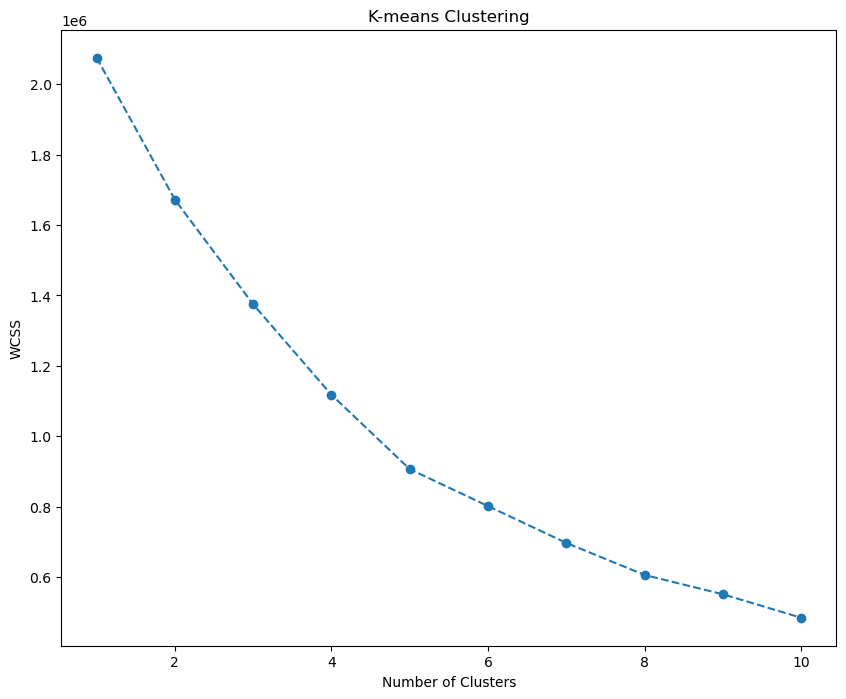

In [74]:
# Plotting the K-means
plt.figure(figsize = (10, 8))
plt.plot(range(1, 11), wcss, marker = 'o', linestyle = '--')
plt.xlabel('Number of Clusters')
plt.ylabel('WCSS')
plt.title('K-means Clustering')
plt.show()

**Using Davies-Bouldin Index to determine the number of clusters**

In [76]:
# davies_bouldin_scores = []
# for i in range(2, 11):
#     kmeans = KMeans(n_clusters=i, init='k-means++', n_init=10, random_state=30)
#     kmeans.fit(cleaned_positive_df)
#     score = davies_bouldin_score(cleaned_positive_df, kmeans.labels_)
#     davies_bouldin_scores.append(score)

# # Plotting the Davies-Bouldin Scores
# plt.figure(figsize=(10, 5))
# plt.plot(range(2, 11), davies_bouldin_scores, marker='o', linestyle='--')
# plt.title('Davies-Bouldin Scores for K-means Clustering')
# plt.xlabel('Number of clusters')
# plt.ylabel('Davies-Bouldin Score')
# plt.xticks(range(2, 11))
# plt.grid(True)
# plt.show()

**Note: Ideal number of clusters based on DB scores: 8**

In [78]:
kmeans = KMeans(n_clusters = 8, init = 'k-means++',  random_state = 30) # Implement number of clusters

In [79]:
kmeans.fit(cleaned_positive_df)

C:\Users\olive\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


KMeans(random_state=30)

### 3.11 K-Means Clustering: Results

In [81]:
df_segm_kmeans = pre_std_df.copy()
df_segm_kmeans['segment k-means'] = kmeans.labels_

In [82]:
df_segm_analysis = df_segm_kmeans.groupby(['segment k-means']).mean()
df_segm_analysis

,Quantity,UnitPrice,DayOfWeek,Month
segment k-means,,,,
0,9.261346,3.892993,0.994626,3.525379
1,8.932725,3.155484,4.200024,10.256926
2,9.189740,3.454245,0.998810,9.909157
3,613.864865,1.291843,2.114251,7.293612
4,1.418440,872.544326,1.865248,9.801418
5,9.516617,3.612367,3.963499,4.045565
6,3613.619048,0.512381,2.809524,5.761905
7,1.000000,4278.730000,2.250000,8.750000


In [83]:
# Calculate the mean values for each segment
df_segm_analysis = df_segm_kmeans.groupby(['segment k-means']).mean()

# Calculate the number of observations for each segment
num_obs = df_segm_kmeans.groupby(['segment k-means']).size()

# Add the number of observations to the analysis DataFrame
df_segm_analysis['num_obs'] = num_obs

# Add column for probability
df_segm_analysis['probability'] = df_segm_analysis['num_obs'] / df_segm_analysis['num_obs'].sum()

df_segm_analysis

,Quantity,UnitPrice,DayOfWeek,Month,num_obs,probability
segment k-means,,,,,,
0,9.261346,3.892993,0.994626,3.525379,107551,0.207340
1,8.932725,3.155484,4.200024,10.256926,139978,0.269854
2,9.189740,3.454245,0.998810,9.909157,171361,0.330355
3,613.864865,1.291843,2.114251,7.293612,814,0.001569
4,1.418440,872.544326,1.865248,9.801418,141,0.000272
5,9.516617,3.612367,3.963499,4.045565,98847,0.190561
6,3613.619048,0.512381,2.809524,5.761905,21,0.000040
7,1.000000,4278.730000,2.250000,8.750000,4,0.000008


In [84]:
df_segm_analysis.rename({0: 'med-med-mon-late_spring', #  quantity / unit price / day of week / month
                         1: 'med-med-fri-winter', 
                         2: 'med-med-mon-autumn/winter',
                         3: 'high-low-wed-autumn',
                         4: 'loe-high-wed-autumn/winter',
                         5: 'low-vhigh-fri-spring',
                         6: 'high-vlow-thurs-spring/summer', 
                         7: 'vlow-vhigh-wed-autumn'})


,Quantity,UnitPrice,DayOfWeek,Month,num_obs,probability
segment k-means,,,,,,
med-med-mon-late_spring,9.261346,3.892993,0.994626,3.525379,107551,0.207340
med-med-fri-winter,8.932725,3.155484,4.200024,10.256926,139978,0.269854
med-med-mon-autumn/winter,9.189740,3.454245,0.998810,9.909157,171361,0.330355
high-low-wed-autumn,613.864865,1.291843,2.114251,7.293612,814,0.001569
loe-high-wed-autumn/winter,1.418440,872.544326,1.865248,9.801418,141,0.000272
low-vhigh-fri-spring,9.516617,3.612367,3.963499,4.045565,98847,0.190561
high-vlow-thurs-spring/summer,3613.619048,0.512381,2.809524,5.761905,21,0.000040
vlow-vhigh-wed-autumn,1.000000,4278.730000,2.250000,8.750000,4,0.000008


In [85]:
df_segm_kmeans['Labels'] = df_segm_kmeans['segment k-means'].map({0: 'med-med-mon-late_spring', #  quantity / unit price / day of week / month
                                                                  1: 'med-med-fri-winter', 
                                                                  2: 'med-med-mon-autumn/winter',
                                                                  3: 'high-low-wed-autumn',
                                                                  4: 'loe-high-wed-autumn/winter',
                                                                  5: 'low-vhigh-fri-spring',
                                                                  6: 'high-vlow-thurs-spring/summer', 
                                                                  7: 'vlow-vhigh-wed-autumn'})


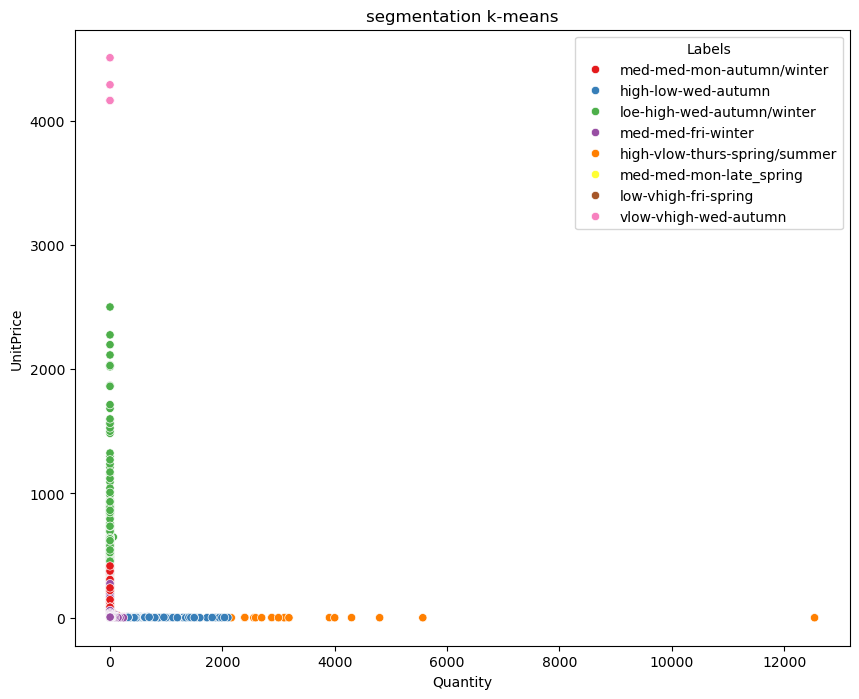

In [86]:
x_axis = df_segm_kmeans['Quantity']
y_axis = df_segm_kmeans['UnitPrice']

plt.figure(figsize = (10, 8))
sns.scatterplot(x = x_axis, y = y_axis, hue= df_segm_kmeans['Labels'], palette=sns.color_palette("Set1", 8))
plt.title('segmentation k-means')
plt.show()

**Note: Good seperation between pink/orange/green/blue clusters. However for lower quantity and price transactions the clusters are grouped together. Should combine k-means with principle component analysis (PCA) to get better insight.**

### 3.2 K- Means clustering with PCA

**Using PCA for dimensionality reduction.**

In [90]:
pca = PCA()
pca.fit(cleaned_positive_df)

PCA()

In [91]:
cleaned_positive_df.head(2)

,Quantity,UnitPrice,DayOfWeek,Month
0,-0.100097,-0.056595,-0.232391,1.264902
1,-0.100097,-0.017320,-0.232391,1.264902


In [92]:
# Show significance of each feature
pca.explained_variance_ratio_

array([0.26098943, 0.25543154, 0.24450051, 0.23907853])

Text(0, 0.5, 'Cumulitive explained variance')

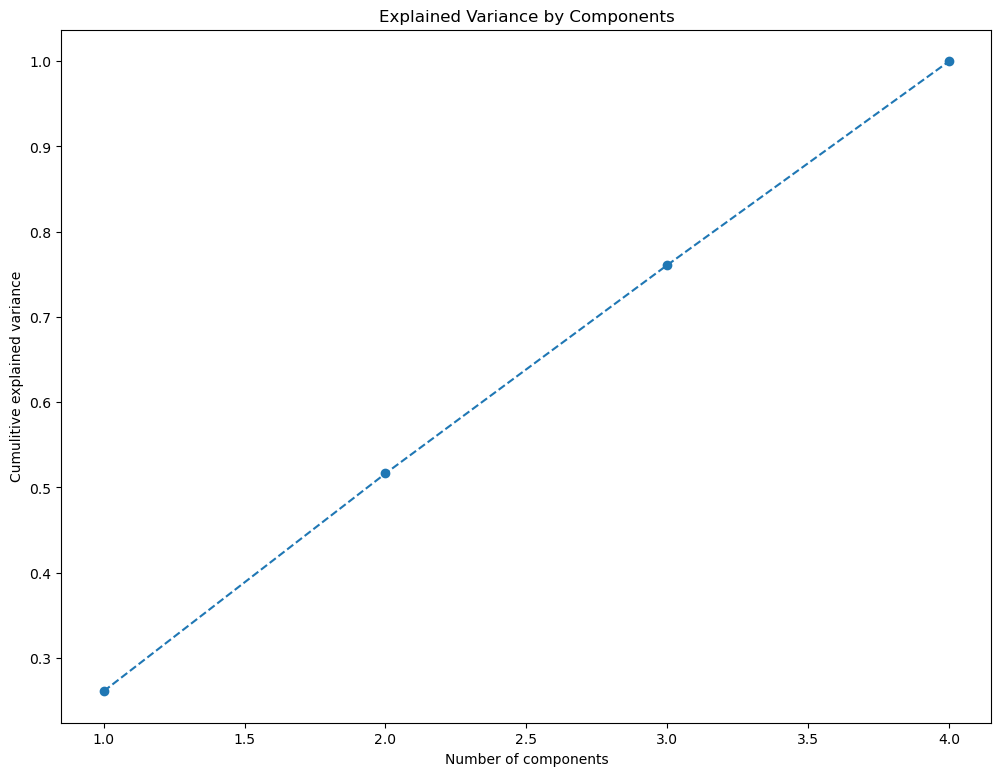

In [93]:
plt.figure(figsize = (12, 9))
plt.plot(range(1, 5), pca.explained_variance_ratio_.cumsum(), marker = 'o', linestyle = '--')
plt.title('Explained Variance by Components')
plt.xlabel('Number of components')
plt.ylabel('Cumulitive explained variance')

In [94]:
# Having three components would retain 76% of the information
pca = PCA(n_components = 3)

In [95]:
pca.fit(cleaned_positive_df)

PCA(n_components=3)

### 3.21 K-Means with PCA

In [97]:
pca.components_ # Loading: Correlation between an original variable and a component

array([[ 0.22871926,  0.08681487, -0.69358214, -0.67756512],
       [ 0.66276442, -0.7345295 ,  0.14448276, -0.01828866],
       [ 0.69142646,  0.59713774, -0.08559711,  0.39752874]])

### 

In [98]:
# Visualise better in a pandas dataframe
df_pca_comp = pd.DataFrame(data = pca.components_,
                          columns = pre_std_df.columns.values,
                          index = ['Component 1', 'Component 2', 'Component 3'])

df_pca_comp

,Quantity,UnitPrice,DayOfWeek,Month
Component 1,0.228719,0.086815,-0.693582,-0.677565
Component 2,0.662764,-0.734529,0.144483,-0.018289
Component 3,0.691426,0.597138,-0.085597,0.397529


([<matplotlib.axis.YTick at 0x16ecd21ba50>,
 [Text(0, 0, 'Component 1'),
  Text(0, 1, 'Component 2'),
  Text(0, 2, 'Component 3')])

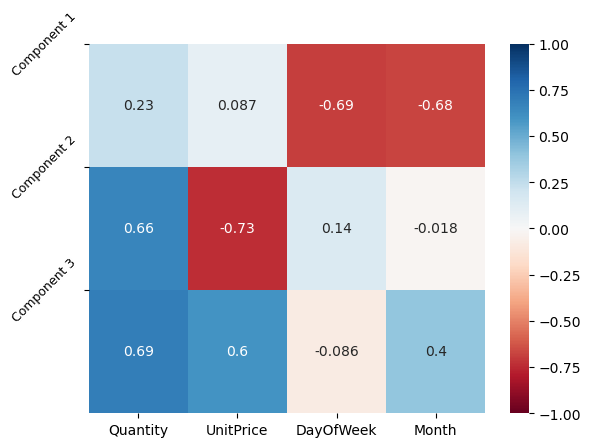

In [99]:
sns.heatmap(df_pca_comp,
           vmin = -1,
           vmax = 1,
           cmap = 'RdBu',
           annot = True)
plt.yticks([0, 1, 2],
           ['Component 1', 'Component 2', 'Component 3'],
           rotation = 45,
           fontsize = 9)


In [100]:
# PCA scores
pca.transform(cleaned_positive_df) # Each observation is described by the 3 components

array([[-0.72367846, -0.08148004,  0.41972178],
       [-0.72026876, -0.11032908,  0.44317469],
       [-0.71219374, -0.05742181,  0.45757033],
       ...,
       [-1.47959573, -0.01075999,  0.33935503],
       [-1.47959573, -0.01075999,  0.33935503],
       [-1.48168484, -0.05369878,  0.34555886]])

In [101]:
score_pca = pca.transform(cleaned_positive_df)

**K-means clustering with PCA**

In [103]:
wcss = []
for i in range(1, 11):
    kmeans_pca = KMeans(n_clusters=i, init='k-means++', n_init=10, random_state=30)
    kmeans_pca.fit(score_pca)
    wcss.append(kmeans_pca.inertia_)


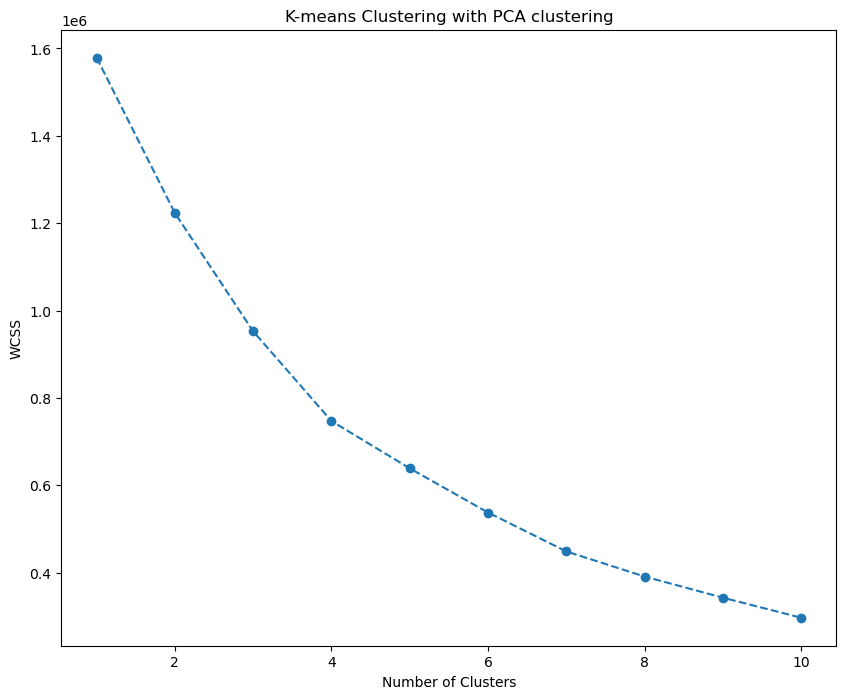

In [104]:
# Plotting the K-means/PCA
plt.figure(figsize = (10, 8))
plt.plot(range(1, 11), wcss, marker = 'o', linestyle = '--')
plt.xlabel('Number of Clusters')
plt.ylabel('WCSS')
plt.title('K-means Clustering with PCA clustering')
plt.show()

In [105]:
kmeans_pca = KMeans(n_clusters = 4, init = 'k-means++', random_state = 30)

In [106]:
kmeans_pca.fit(score_pca)

C:\Users\olive\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


KMeans(n_clusters=4, random_state=30)

**K-means clustering with PCA Results**

In [211]:
df_segm_pca_kmean = pd.concat([pre_std_df.reset_index(drop = True) ,pd.DataFrame(score_pca)], axis = 1)
df_segm_pca_kmean.columns.values[-3:] = ['Component 1', 'Component 2', 'Component 3']
df_segm_pca_kmean['Segment K-means PCA'] = kmeans_pca.labels_

In [213]:
df_segm_pca_kmean

,Quantity,UnitPrice,DayOfWeek,Month,Component 1,Component 2,Component 3,Segment K-means PCA
0,6,2.55,2,12,-0.723678,-0.081480,0.419722,1
1,6,3.39,2,12,-0.720269,-0.110329,0.443175,1
2,8,2.75,2,12,-0.712194,-0.057422,0.457570,1
3,6,3.39,2,12,-0.720269,-0.110329,0.443175,1
4,6,3.39,2,12,-0.720269,-0.110329,0.443175,1
...,...,...,...,...,...,...,...,...
518712,12,0.85,4,12,-1.450299,0.226284,0.376277,1
518713,6,2.10,4,12,-1.477244,0.090572,0.314383,1
518714,4,4.15,4,12,-1.479596,-0.010760,0.339355,1
518715,4,4.15,4,12,-1.479596,-0.010760,0.339355,1


In [215]:
df_segm_pca_kmean_freq = df_segm_pca_kmean.groupby(['Segment K-means PCA']).mean()
df_segm_pca_kmean_freq

,Quantity,UnitPrice,DayOfWeek,Month,Component 1,Component 2,Component 3
Segment K-means PCA,,,,,,,
0,9.621348,3.698477,1.472577,5.091143,0.831480,-0.070243,-0.247358
1,8.961932,3.357405,3.296632,9.793043,-0.766170,0.049610,0.180089
2,747.729692,1.190042,2.130252,7.313725,4.084168,11.469583,11.811035
3,1.500000,1076.353729,1.940678,10.262712,3.968530,-37.025480,30.133964


In [217]:
df_segm_pca_kmean_freq['num_obs'] = df_segm_pca_kmean[['Segment K-means PCA', 'Quantity']].groupby(['Segment K-means PCA']).count()
df_segm_pca_kmean_freq['probability'] = df_segm_pca_kmean_freq['num_obs'] / df_segm_pca_kmean_freq['num_obs'].sum()
df_segm_pca_kmean_freq = df_segm_pca_kmean_freq.rename({0: 'Seasonal-Early',
                                                        1: 'Seasonal-Late',
                                                        2: 'High quantity customers',
                                                        3: 'High price items'})
df_segm_pca_kmean_freq

,Quantity,UnitPrice,DayOfWeek,Month,Component 1,Component 2,Component 3,num_obs,probability
Segment K-means PCA,,,,,,,,,
Seasonal-Early,9.621348,3.698477,1.472577,5.091143,0.831480,-0.070243,-0.247358,246239,0.474708
Seasonal-Late,8.961932,3.357405,3.296632,9.793043,-0.766170,0.049610,0.180089,271646,0.523688
High quantity customers,747.729692,1.190042,2.130252,7.313725,4.084168,11.469583,11.811035,714,0.001376
High price items,1.500000,1076.353729,1.940678,10.262712,3.968530,-37.025480,30.133964,118,0.000227


In [219]:
df_segm_pca_kmean['Legend'] = df_segm_pca_kmean['Segment K-means PCA'].map({0: 'Seasonal-Early',
                                                        1: 'Seasonal-Late',
                                                        2: 'High quantity customers',
                                                        3: 'High price items'})

C:\Users\olive\AppData\Local\Temp\ipykernel_15772\3907730473.py:4: UserWarning: The palette list has more values (8) than needed (4), which may not be intended.
  sns.scatterplot(x=x_axis, y=y_axis, hue=df_segm_pca_kmean['Legend'], palette=sns.color_palette("Set1", 8))


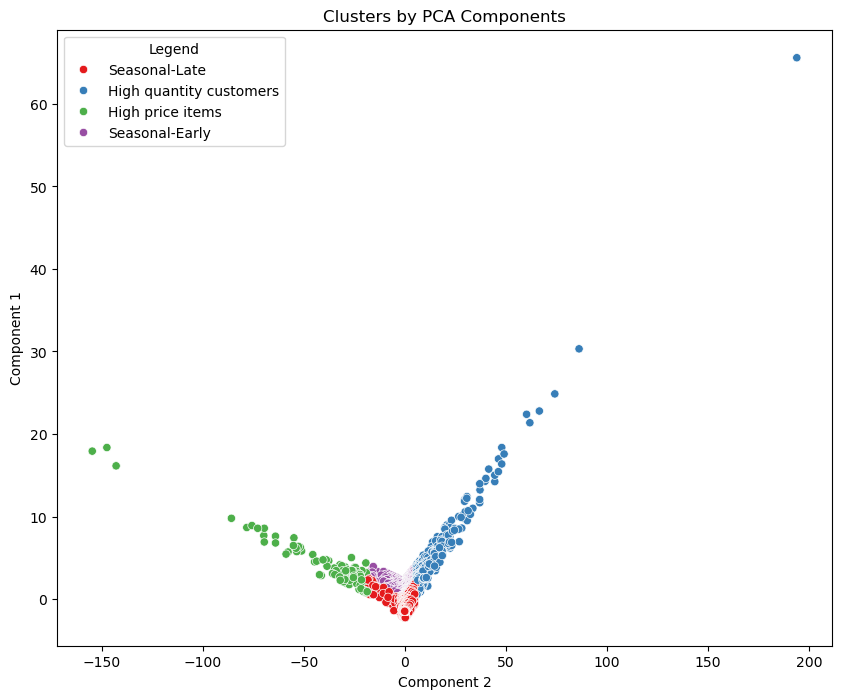

In [223]:
x_axis = df_segm_pca_kmean['Component 2']
y_axis = df_segm_pca_kmean['Component 1']
plt.figure(figsize = (10, 8))
sns.scatterplot(x=x_axis, y=y_axis, hue=df_segm_pca_kmean['Legend'], palette=sns.color_palette("Set1", 8))
plt.title('Clusters by PCA Components')
plt.show()

Business Interpretation
The PCA and K-means clustering analysis has resulted in four distinct customer segments, each with unique characteristics based on purchasing behavior. Below is an interpretation of each segment:

**1. Seasonal-Early Customers**</br>
Characteristics:
Quantity: Moderate purchase quantities (9.62 units on average).
Unit Price: Low average unit price ($3.70).
Day of Week: Tend to make purchases early in the week (average DayOfWeek of 1.47).
Month: More purchases in the earlier part of the year (average Month of 5.09, likely around spring or early summer).
Components:
Component 1: Positive (0.83), driven by temporal factors suggesting early-week and earlier-month purchases.
Component 2 & 3: Neutral to slightly negative, indicating less influence from high quantity or high price behaviors.
Segment Size: Represents 47.47% of the dataset (246,239 observations).
Business Insight: These customers are likely driven by early seasonal promotions and tend to buy in moderate quantities at lower prices. They are responsive to sales and deals offered early in the season.

**2. Seasonal-Late Customers**</br>
Characteristics:
Quantity: Similar to the early group but slightly lower (8.96 units on average).
Unit Price: Low average unit price ($3.36).
Day of Week: Purchase activity later in the week (average DayOfWeek of 3.30).
Month: Purchases skewed towards the latter part of the year (average Month of 9.79, around fall or early winter).
Components:
Component 1: Negative (-0.77), indicating late-week and late-season purchasing behavior.
Component 2 & 3: Neutral to slightly positive, with less influence from high quantity or high price purchases.
Segment Size: Represents 52.37% of the dataset (271,646 observations).
Business Insight: This segment is likely influenced by end-of-season sales and promotions, purchasing later in the week and year. They may respond well to last-minute offers and discounts leading into the holiday season.

**3. High Quantity Customers**</br>
Characteristics:
Quantity: Extremely high purchase quantities (747.73 units on average).
Unit Price: Very low average unit price ($1.19).
Day of Week: Purchases are spread throughout the week (average DayOfWeek of 2.13).
Month: Purchases occur in mid-year months (average Month of 7.31).
Components:
Component 1: Strongly positive (4.08), driven by high quantity purchases.
Component 2: Extremely positive (11.47), indicating a significant focus on bulk buying at low prices.
Component 3: Positive (11.81), emphasizing the large volume of purchases.
Segment Size: Very small segment, representing 0.14% of the dataset (714 observations).
Business Insight: This segment consists of bulk buyers, possibly B2B customers or resellers. They are price-sensitive and buy in large quantities, making them ideal for wholesale pricing and bulk discount offers.

**4. High Price Items Customers**</br>
Characteristics:
Quantity: Very low purchase quantities (1.5 units on average).
Unit Price: Extremely high average unit price ($1076.35).
Day of Week: Purchases are evenly distributed across the week (average DayOfWeek of 1.94).
Month: Purchases tend to occur late in the year (average Month of 10.26).
Components:
Component 1: Highly positive (3.97), indicating purchases of expensive items.
Component 2: Strongly negative (-37.03), showing a sharp distinction from bulk purchasing.
Component 3: Very positive (30.13), indicating a focus on high-value items.
Segment Size: The smallest segment, representing 0.02% of the dataset (118 observations).
Business Insight: This segment includes customers who purchase high-ticket items. They are likely to respond to luxury branding, premium services, and personalized experiences. Targeted marketing for exclusive products and VIP offers would be effective.
Communicate the Results
Executive Summary
The customer segmentation analysis revealed four distinct groups: Seasonal-Early, Seasonal-Late, High Quantity, and High Price Items customers. Each segment exhibits unique purchasing behaviors driven by factors such as seasonality, purchase volume, and price sensitivity. These insights can be leveraged to tailor marketing strategies, optimize pricing models, and enhance customer engagement.

**Recommendations**</br>
Seasonal-Early Customers: Focus on early-season promotions, targeting these customers with deals and discounts in the spring and early summer.</br>
Seasonal-Late Customers: Implement end-of-season sales and holiday promotions to capture these late-season buyers. Consider pushing last-minute offers.</br>
High Quantity Customers: Develop wholesale pricing models and bulk discount programs to cater to these price-sensitive, high-volume buyers.</br>
High Price Items Customers: Offer premium services, exclusive deals, and personalized marketing to attract and retain these high-value customers.</br>

**Next Steps**
Targeted Campaigns: Launch personalized marketing campaigns for each segment to increase customer engagement and drive sales.
Product Development: Adjust product offerings and inventory based on the demand patterns observed in each segment.
Monitor and Iterate: Continuously monitor customer behavior within these segments and adjust strategies as needed to maintain relevance and effectiveness.